In [1]:
import numpy as np
import pandas as pd

import cebra
from cebra import CEBRA

from dataframe.csv_utils import (
    load_data_from_csv,
)

from labels import get_behavioral_labels

from constants import SUEJECT_BATCHES, SORTED_BLOCK_NAMES, V_COLOR_MAP, AUDIO_BLOCKS

In [ ]:
# import importlib
# import labels
# importlib.reload(labels)

In [2]:
from data_utils import (
    load_data_from_dir,
)

subj_to_data = {}
data_dir = '../CleandDataV2/'
for subj in [2017, 2026, 2028, 2033,  2037, 2041]:
    dir_name = data_dir + str(subj)
    all_data = load_data_from_dir(dir_name)
    subj_to_data[subj] = all_data

Loading ../CleandDataV2/2017 data...
Loading ../CleandDataV2/2026 data...
Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2033 data...
Loading ../CleandDataV2/2037 data...
Loading ../CleandDataV2/2041 data...


In [3]:
from features.psd import welch_bandpower
from feature_extraction import EEG_BANDS, Feature


def get_psd(trial_data, srate, band):
    low, high = band
    freqs, psd = welch_bandpower(trial_data, srate, None, 2)

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    return psd[idx_band]


def get_psd_by_channel(block_data, marker, channel_type: str, feature: Feature):
    psd_data = []
    time_series_data = block_data.get_all_data()[marker]

    # loop through all trials: time -> frequency
    for t in range(time_series_data.shape[2]):
        all_channel_psd = []
        for i, c in enumerate(block_data.get_chanlocs(marker)):
            if not c.startswith(channel_type):
                continue

            data = time_series_data[i]
            psd = get_psd(data[:, t], block_data.get_srate(marker), EEG_BANDS[feature])
            all_channel_psd = (
                np.hstack((all_channel_psd, psd)) if len(all_channel_psd) > 0 else psd
            )

        psd_data = (
            np.vstack((psd_data, all_channel_psd))
            if len(psd_data) > 0
            else all_channel_psd
        )

    return psd_data


def get_block_features(blocks, subject_data, marker, channel, feature):
    raw_data = []
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        psd_data = get_psd_by_channel(block_data, marker, channel, feature)

        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

        raw_data = np.vstack((psd_data, raw_data)) if len(raw_data) > 0 else psd_data

    return raw_data, behavioral_labels


In [15]:
subj = 2037
subject_data = subj_to_data[subj]

marker = "EEG"
channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
for c in ["A", "B", "C", "D"]:
    for f in EEG_BANDS.keys():
        raw_data, behavioral_labels = get_block_features(
            AUDIO_BLOCKS, subject_data, marker, c, f
        )
        channel_feature_to_data[c][f] = raw_data

print(behavioral_labels)

['hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvha', 'hvla', 'hvha', 'hvla', 'hvla', 'hvla', 'hvla', 'hvla', 'nvla', 'hvha', 'hvla', 'hvla', 'hvla', 'nvla']


### Load EEG average power spectral features

In [ ]:
dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)

In [ ]:
subjects = result['Subject'].unique()

all_blocks = []
for b in SORTED_BLOCK_NAMES:
    all_blocks.extend([b] * 13)


result["condition"] = all_blocks * len(subjects)
mask = result["condition"].isin(AUDIO_BLOCKS)
audio_only = result[mask]
audio_only

In [ ]:
# First subject only
subject_data = audio_only[audio_only['Subject'].isin([2000])]
neural_data = subject_data.drop(columns=['Valence', 'Arousal', 'Attention', 'Subject', 'condition'])
v_label = subject_data['Valence']
a_label = subject_data['Arousal']

behavioral_labels = [get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))]
print(neural_data.shape, len(behavioral_labels))

### Model Training

In [17]:
def model_fit(neural_data, out_dim, num_hidden_units, behavioral_labels):
    single_cebra_model = CEBRA(
       # model_architecture = "offset10-model",    
        batch_size=512,
        output_dimension=out_dim,
        max_iterations=10,
        num_hidden_units=num_hidden_units,
        max_adapt_iterations=10)
    
    single_cebra_model.fit(neural_data, behavioral_labels)
    #cebra.plot_loss(single_cebra_model)
    return single_cebra_model

### Visualize embedding

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  self.ax.scatter(
/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  self.ax.scatter(
/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  self.ax.scatter(
/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  self.ax.scatter(
/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/cebra/integrations/matplotlib.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'c

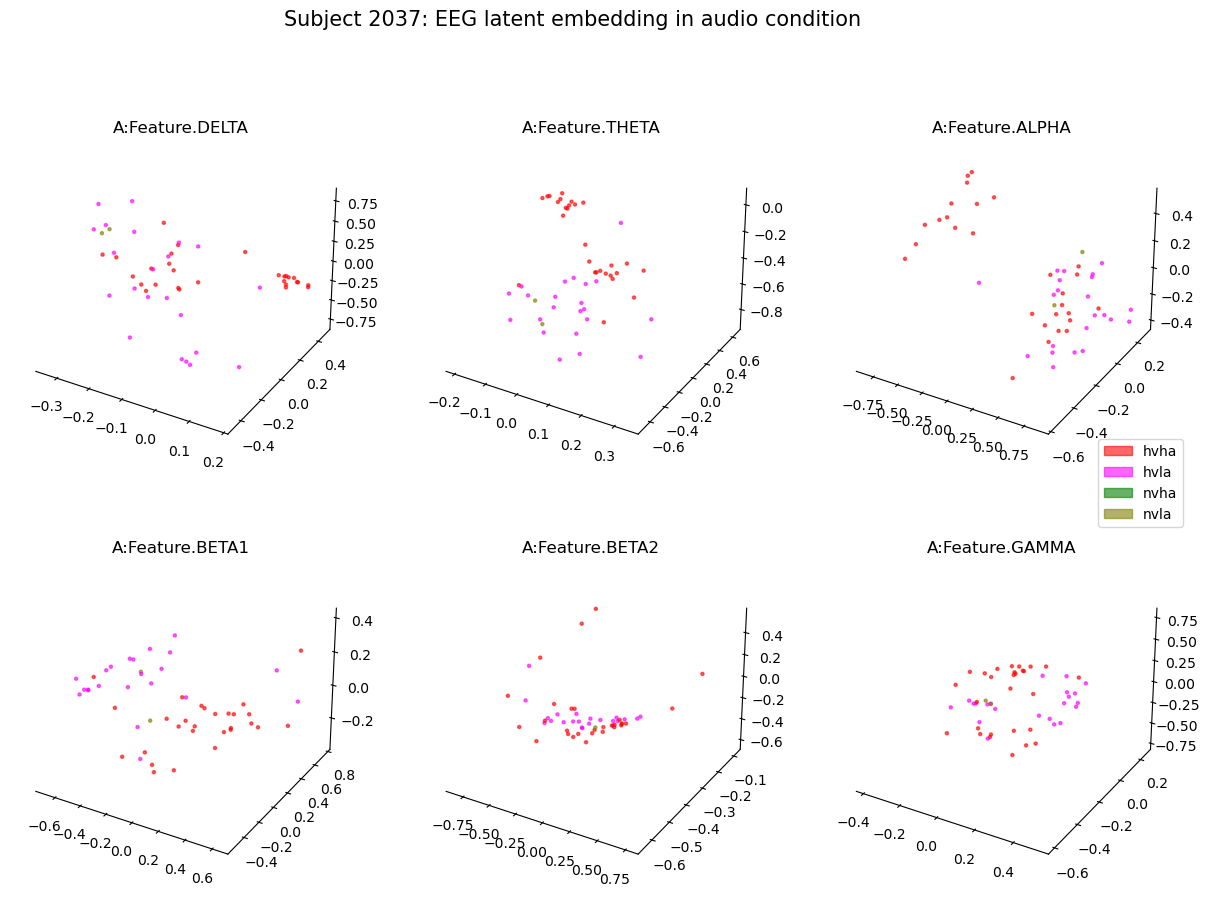

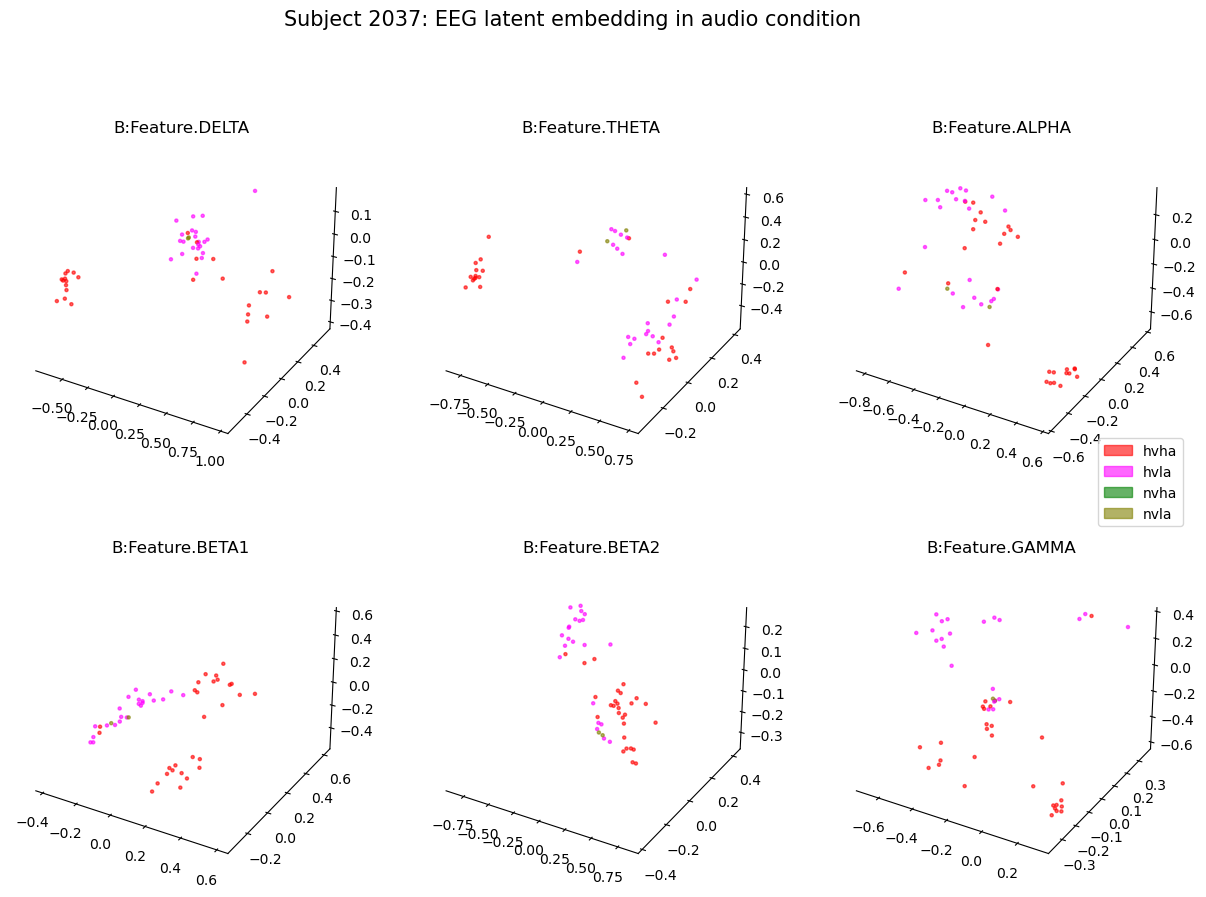

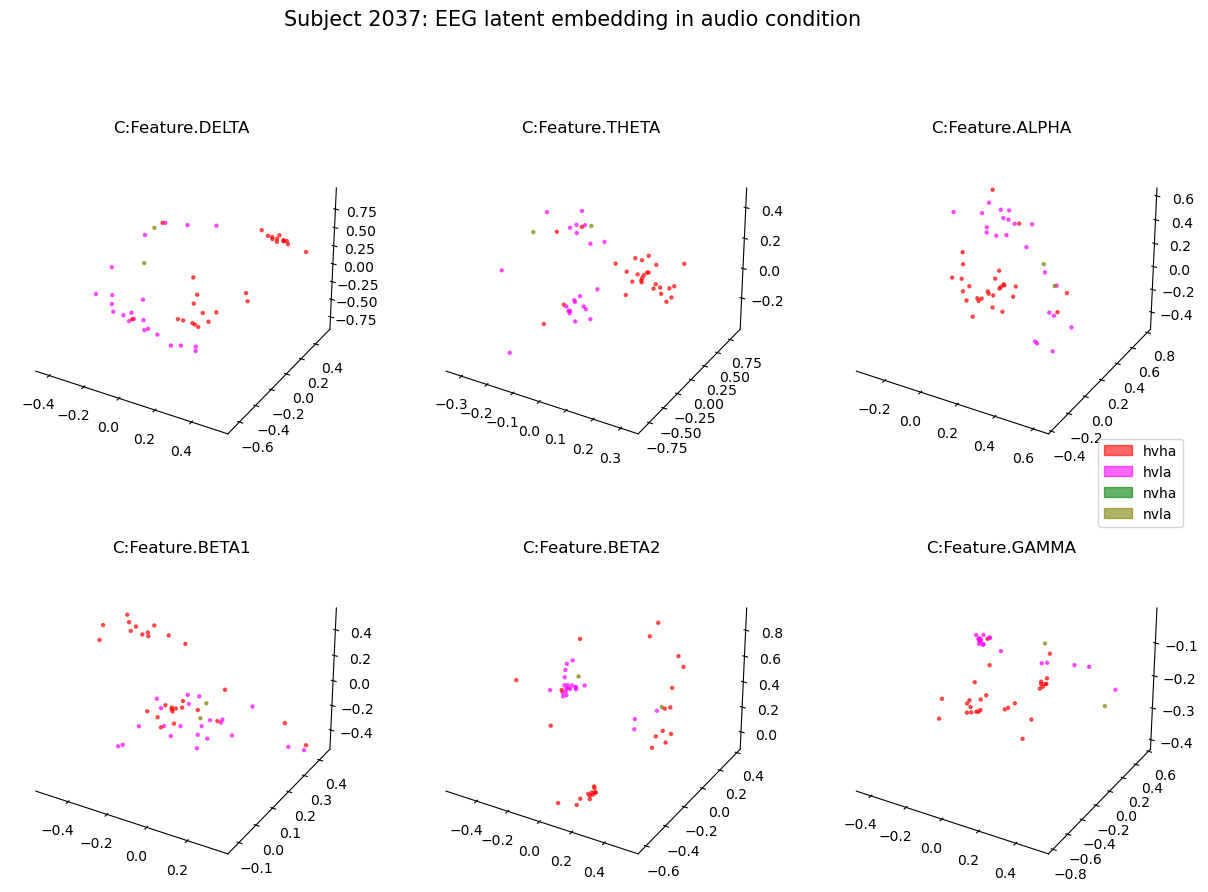

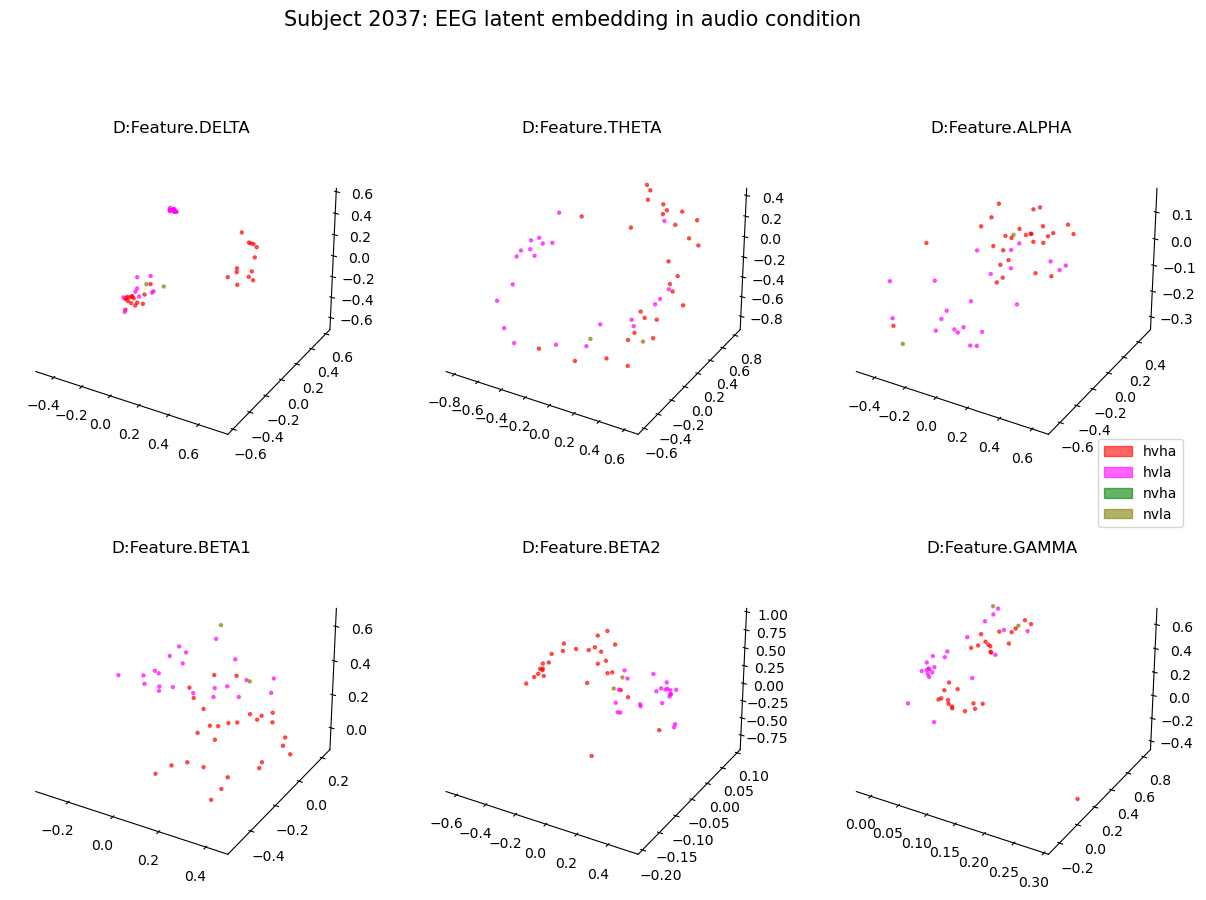

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
    "lvha": "blue",
    "lvla": "steelblue",
}

cmap = [V_COLOR_MAP[l] for l in behavioral_labels]
labels = [IDX_MAP[l] for l in behavioral_labels]
for channel, feature_to_data in channel_feature_to_data.items():
    nrows = 2
    ncols = int(len(feature_to_data) / 2)
    fig, axes = plt.subplots(
        nrows=2,
        ncols=ncols,
        figsize=(ncols * 5, nrows * 5),
        subplot_kw=dict(projection="3d"),
    )

    idx = 0
    output_dim = 8
    max_hidden_units = 256

    for f, neural_data in feature_to_data.items():
        single_cebra_model = model_fit(
            neural_data, output_dim, max_hidden_units, np.array(labels)
        )
        embedding = single_cebra_model.transform(neural_data)

        ax = cebra.plot_embedding(
            embedding,
            embedding_labels=np.array(cmap),
            title=f"{channel}:{f}",
            ax=axes.flat[idx],
            markersize=5,
            alpha=0.6,
        )
        idx += 1


    plt.legend(
        handles=[
            mpatches.Patch(color="red", label="hvha",  alpha=0.6),
            mpatches.Patch(color="magenta", label="hvla",  alpha=0.6),
            mpatches.Patch(color="green", label="nvha",  alpha=0.6),
            mpatches.Patch(color="olive", label="nvla",  alpha=0.6)
        ],
        loc='lower right',
        bbox_to_anchor=(1.05, 1)
    )
    fig.suptitle(
        f"Subject {subj}: {marker} latent embedding in audio condition",
        fontsize=15,
    )

    #plt.savefig(f"results/cebra/cebra_{subj}_eeg_bands_channel_{channel}_O{output_dim}H{max_hidden_units}.png")

In [11]:
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension=[6, 8],
    learning_rate=[3e-4],
    max_iterations=10,
    num_hidden_units=[32, 64, 128, 256],
    max_adapt_iterations=10,
    temperature_mode="auto",
    verbose=False,
)

# 2. Define the datasets to iterate over
datasets = {
    "neural_data": channel_feature_to_data["C"][Feature.THETA],
}

# 3. Create and fit the grid search to your data
grid_search = cebra.grid_search.GridSearch()
grid_search = grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

# 4. Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")
# 5. Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name="neural_data", models_dir="saved_models")

In [12]:
best_model_name

'num_hidden_units_256_output_dimension_8_neural_data'

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1 = cebra.plot_embedding(embedding, embedding_labels=np.array(cmap), idx_order=(1,2,3), title="Latents: (1,2,3)", ax=ax1, markersize=5, alpha=0.6)
ax2 = cebra.plot_embedding(embedding, embedding_labels=np.array(cmap), idx_order=(4,5,6), title="Latents: (4,5,6)", ax=ax2, markersize=5, alpha=0.6)